In [2]:
# from db_connection import DB_Connection
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import TextBox
import re, json
from wordcloud import WordCloud
# import Tweet
from sklearn.svm import LinearSVC
import pickle
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, multilabel_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../data.csv', encoding='utf-8')

## Plot data

In [9]:
incidents = df[['tweet_id','isincident']].groupby('isincident').size()
accidents = df[['tweet_id','isaccident']].groupby('isaccident').size()[1]
dangers = df[['tweet_id','isdanger']].groupby('isdanger').size()[1]
obstacles = df[['tweet_id','isobstacle']].groupby('isobstacle').size()[1]

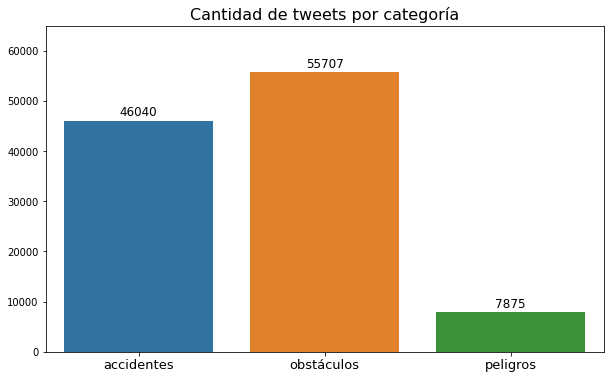

In [11]:
x = [0,1,2]
data = [accidents,obstacles,dangers]
plt.figure(figsize=(10,6))
g = sns.barplot(x=x, y=data)
plt.title('Cantidad de tweets por categoría', fontsize=16)
plt.xticks(ticks=x,
        labels=['accidentes','obstáculos','peligros'],
        fontsize=13)
plt.ylim(top=65000)

for i, v in enumerate(data):
    g.text(i, v+1000, v, color='black', ha="center", fontsize=12)
    # plt.annotate(v, (i+3, 10), color='black', fontsize=12)
plt.show()

## Text classification

In [ ]:
# joined = ' '.join([t for t in classified.clean])
# joined = joined.split()
# new_joined = pd.Series(joined)
# len(new_joined.unique())

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(max_features=600, min_df=5, max_df=0.7)
X11 = vectorizer1.fit_transform(df.clean_text).toarray()

In [4]:
y = [i for i in df[['isaccident','isobstacle','isdanger']].values]

In [5]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X11, y, test_size=0.2, random_state=0)

## Get vect models

In [13]:
# load model fo 3000 features
with open('vectorizer3000', 'rb') as v:
    vect = pickle.load(v)

In [17]:
# convert and split data
X_vect = vect.transform(df.clean_text).toarray()
y = [i for i in df[['isaccident','isobstacle','isdanger']].values]
print('Creating train-test data...')
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=0)
print('Done.')

Creating train-test data...
Done.


## Categ Model

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb
import time
from xgboost import DMatrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Preliminar trainign

In [7]:
start = time.time()
xgb_first = XGBClassifier(use_label_encoder=False)
mo_classifier = MultiOutputClassifier(xgb_first).fit(X_train1, y_train1)
# xgb_first.fit(X_train1, y_train1)
end = time.time()
print('Duration:', str(end-start))
y_xgb_first = mo_classifier.predict(X_test1)

C:\Users\lucia\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[22:48:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:51:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Duration: 325.42959547042847


In [8]:
for i in range(3):
    ytest0 = [j[i] for j in y_test1] 
    ypred0 = [j[i] for j in y_xgb_first]
    print('Acurracy data[%d]'%i, accuracy_score(ytest0, ypred0))

Acurracy data[0] 0.969029996104402
Acurracy data[1] 0.9452668484612388
Acurracy data[2] 0.9731203739774056


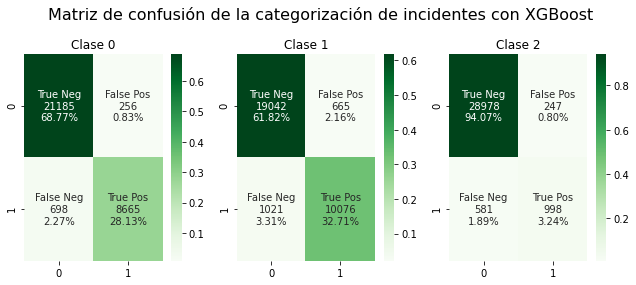

In [13]:
conf_matrix = multilabel_confusion_matrix(y_test1,y_xgb_first)

plt.figure(figsize=(9,4))
plt.suptitle('Matriz de confusión de la categorización de incidentes con XGBoost', fontsize=16)
for i in range(3):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    conf_matrix[i].flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        conf_matrix[i].flatten()/np.sum(conf_matrix[i])]
    labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.subplot(1, 3, i+1)
    sns.heatmap(conf_matrix[i]/np.sum(conf_matrix[i]), annot=labels, fmt='', cmap='Greens')
    plt.title('Clase %d'%i, fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
start = time.time()
rf_first = RandomForestClassifier(n_jobs=4)
mo_rf_classifier = MultiOutputClassifier(rf_first).fit(X_train1, y_train1)
# xgb_first.fit(X_train1, y_train1)
end = time.time()
print('Duration:', str(end-start))
y_rf_first = mo_rf_classifier.predict(X_test1)

Duration: 228.74702835083008


In [11]:
for i in range(3):
    ytest1 = [j[i] for j in y_test1] 
    ypred1 = [j[i] for j in y_rf_first]
    print('Acurracy data[%d]'%i, accuracy_score(ytest1, ypred1))

Acurracy data[0] 0.9727308141799766
Acurracy data[1] 0.9551681599792234
Acurracy data[2] 0.9782820412933385


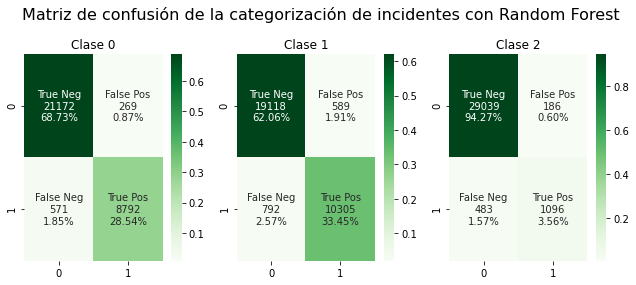

In [14]:
conf_matrix1 = multilabel_confusion_matrix(y_test1,y_rf_first)

plt.figure(figsize=(9,4))
plt.suptitle('Matriz de confusión de la categorización de incidentes con Random Forest', fontsize=16)
for i in range(3):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    conf_matrix1[i].flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        conf_matrix1[i].flatten()/np.sum(conf_matrix1[i])]
    labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.subplot(1, 3, i+1)
    sns.heatmap(conf_matrix1[i]/np.sum(conf_matrix1[i]), annot=labels, fmt='', cmap='Greens')
    plt.title('Clase %d'%i, fontsize=12)
plt.tight_layout()
plt.show()

### Parameter tuning

In [8]:
param_test0 = {
 'max_depth':range(100, 1100, 100)
}

start = time.time()
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=6,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, 
                                        eval_metric='error', seed=27), 
                        param_grid = param_test0, scoring='accuracy',n_jobs=4, cv=3, verbose=2)


param_test0 = {
 'max_depth':range(100, 1100, 100)
}

print(time.asctime())
start = time.time()
gsearch0 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=200, max_depth=100, n_jobs=4), 
                        param_grid = param_test0, scoring='accuracy', n_jobs=1, cv=3, verbose=3)
grid_result0 = MultiOutputClassifier(gsearch0).fit(X_train1, y_train1)
end = time.time()
print(str(end-start))
with open('param_test0', 'wb') as picklefile:
    pickle.dump(grid_result0, picklefile)
for i in range(3):
    grid_results0 = pd.DataFrame(grid_result0.estimators_[i].cv_results_)
    grid_results0.to_csv('grid_results0-%d.csv'%(i))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
6813.413553237915


### Estimators adjust

In [18]:
moresume = []
# mo_arr = []

for i in [100, 200, 300, 500, 700, 1000, 1200, 1500, 1800, 2000, 2500]: # 3000, 3500, 4000, 5000]:
    print('\nestimators:', str(i))
    start = time.time()
    rf = RandomForestClassifier(n_estimators=i, n_jobs=6)
    mo = MultiOutputClassifier(rf)
    # mo_arr.append(mo)
    print('Fitting... ', time.asctime())
    mo.fit(X_train1, y_train1)
    end = time.time()
    print('Predicting... ', time.asctime())
    y_rf = mo.predict(X_test1)
    print(str(end-start), accuracy_score(y_test1, y_rf))
    moresume.append([i, end-start, accuracy_score(y_test1, y_rf), multilabel_confusion_matrix(y_test1,y_rf), classification_report(y_test1,y_rf,zero_division=1)])
    with open('moresume', 'wb') as picklefile:
        pickle.dump(moresume, picklefile)
    with open(f'mo_{i}', 'wb') as picklefile:
        pickle.dump(mo, picklefile)


estimators: 100
Fitting...  Fri Oct  8 22:17:42 2021
Predicting...  Fri Oct  8 22:22:29 2021
287.716495513916 0.9189715621347877

estimators: 200
Fitting...  Fri Oct  8 22:22:32 2021
Predicting...  Fri Oct  8 22:31:43 2021
550.586879491806 0.9180301259576679

estimators: 300
Fitting...  Fri Oct  8 22:31:48 2021
Predicting...  Fri Oct  8 22:45:26 2021
817.9510099887848 0.9188417088689781

estimators: 500
Fitting...  Fri Oct  8 22:45:36 2021
Predicting...  Fri Oct  8 23:08:54 2021
1399.173654794693 0.9187767822360733

estimators: 700
Fitting...  Fri Oct  8 23:09:07 2021
Predicting...  Fri Oct  8 23:40:40 2021
1892.8840734958649 0.91900402545124

estimators: 1000
Fitting...  Fri Oct  8 23:40:57 2021
Predicting...  Sat Oct  9 00:26:22 2021
2724.816813468933 0.9191014154005973

estimators: 1200
Fitting...  Sat Oct  9 00:27:03 2021
Predicting...  Sat Oct  9 01:20:55 2021
3232.9044003486633 0.9193611219322166

estimators: 1500
Fitting...  Sat Oct  9 01:21:34 2021
Predicting...  Sat Oct  9 02

In [19]:
moresume = []
# mo_arr = []

for i in [1500, 1600, 1700, 1800, 1900, 2000]: # 3000, 3500, 4000, 5000]:
    print('\nestimators:', str(i))
    start = time.time()
    rf = RandomForestClassifier(n_estimators=i, n_jobs=6)
    mo = MultiOutputClassifier(rf)
    # mo_arr.append(mo)
    print('Fitting... ', time.asctime())
    mo.fit(X_train1, y_train1)
    end = time.time()
    print('Predicting... ', time.asctime())
    y_rf = mo.predict(X_test1)
    print(str(end-start), accuracy_score(y_test1, y_rf))
    moresume.append([i, end-start, accuracy_score(y_test1, y_rf), multilabel_confusion_matrix(y_test1,y_rf), classification_report(y_test1,y_rf,zero_division=1)])
    with open('moresume2', 'wb') as picklefile:
        pickle.dump(moresume, picklefile)
    with open(f'mo2_{i}', 'wb') as picklefile:
        pickle.dump(mo, picklefile)


estimators: 1500
Fitting...  Sat Oct  9 08:49:10 2021
Predicting...  Sat Oct  9 09:58:12 2021
4147.064667701721 0.9196208284638359

estimators: 1600
Fitting...  Sat Oct  9 09:59:34 2021
Predicting...  Sat Oct  9 11:12:15 2021
4361.5419681072235 0.9199129983119075

estimators: 1700
Fitting...  Sat Oct  9 11:13:35 2021
Predicting...  Sat Oct  9 12:31:06 2021
4651.260243177414 0.9194260485651214

estimators: 1800
Fitting...  Sat Oct  9 12:32:44 2021
Predicting...  Sat Oct  9 13:55:00 2021
4937.97970700264 0.9191014154005973

estimators: 1900
Fitting...  Sat Oct  9 13:57:05 2021
Predicting...  Sat Oct  9 15:19:36 2021
4951.158095598221 0.9188417088689781

estimators: 2000
Fitting...  Sat Oct  9 15:21:23 2021
Predicting...  Sat Oct  9 16:39:13 2021
4672.416410923004 0.9191988053499546


In [9]:
with open('moresume2', 'rb') as picklefile:
    moresume2 = pickle.load(picklefile)
with open('moresume', 'rb') as picklefile:
    moresume1 = pickle.load(picklefile)

In [20]:
for i in moresume1:
    for j in i:
        print(j)

100
287.716495513916
0.9189715621347877
[[[21181   260]
  [  577  8786]]

 [[19116   591]
  [  791 10306]]

 [[29045   180]
  [  474  1105]]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      9363
           1       0.95      0.93      0.94     11097
           2       0.86      0.70      0.77      1579

   micro avg       0.95      0.92      0.93     22039
   macro avg       0.93      0.86      0.89     22039
weighted avg       0.95      0.92      0.93     22039
 samples avg       0.97      0.95      0.92     22039

200
550.586879491806
0.9180301259576679
[[[21160   281]
  [  568  8795]]

 [[19105   602]
  [  800 10297]]

 [[29042   183]
  [  478  1101]]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      9363
           1       0.94      0.93      0.94     11097
           2       0.86      0.70      0.77      1579

   micro avg       0.95      0.92      0.93     22039
   macro 

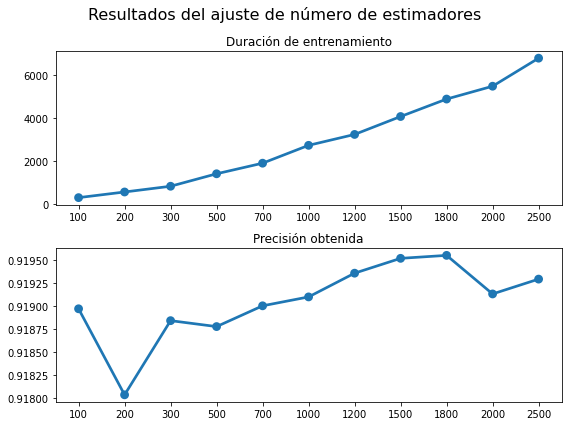

In [21]:
xs = [i[0] for i in moresume1]
ys = [i[1] for i in moresume1]
zs = [i[2] for i in moresume1]

plt.figure(figsize=(8,6))
plt.suptitle('Resultados del ajuste de número de estimadores', fontsize=16)
plt.subplot(2, 1, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(2, 1, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.tight_layout()
plt.show()

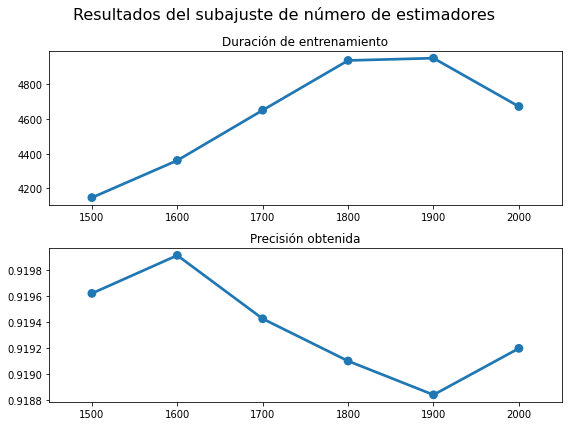

In [23]:
xs = [i[0] for i in moresume2]
ys = [i[1] for i in moresume2]
zs = [i[2] for i in moresume2]

plt.figure(figsize=(8,6))
plt.suptitle('Resultados del subajuste de número de estimadores', fontsize=16)
plt.subplot(2, 1, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(2, 1, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.tight_layout()
plt.show()

array([[[21172,   269],
        [  562,  8801]],

       [[19112,   595],
        [  782, 10315]],

       [[29046,   179],
        [  478,  1101]]], dtype=int64)

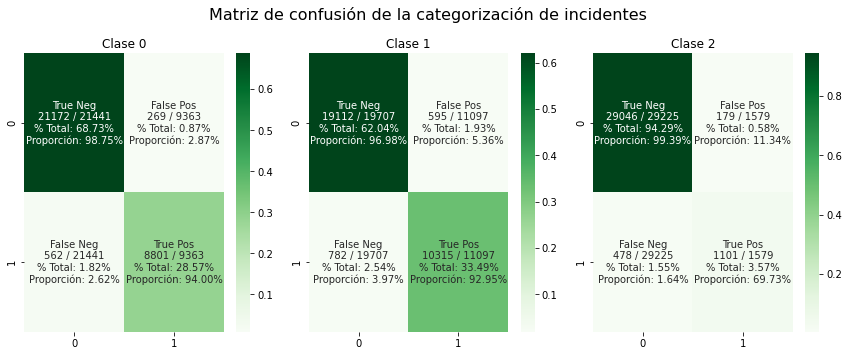

In [42]:
# conf_matrix = multilabel_confusion_matrix(y_test1,y_mo_final)
conf_matrix = moresume2[2][3]

plt.figure(figsize=(12,5))
plt.suptitle('Matriz de confusión de la categorización de incidentes', fontsize=16)
for i in range(3):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    lst = conf_matrix[i].flatten()
    neg = lst[0]+lst[1]
    pos = lst[2]+lst[3]
    counts = [neg, pos, neg, pos]
    group_counts = ['{0:0.0f}'.format(value) for value in
                    conf_matrix[i].flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        conf_matrix[i].flatten()/np.sum(conf_matrix[i])]
    group_accuracy = ['{0:.2%}'.format(value) for value in
                     lst/counts]
    labels = ['%s\n%s / %s\n%% Total: %s\nProporción: %s' % (v1, v2, v4, v3, v5) for v1, v2, v3, v4, v5 in
          zip(group_names,group_counts,group_percentages, counts, group_accuracy)]
    labels = np.asarray(labels).reshape(2,2)
    plt.subplot(1, 3, i+1)
    sns.heatmap(conf_matrix[i]/np.sum(conf_matrix[i]), annot=labels, fmt='', cmap='Greens')
    plt.title('Clase %d'%i, fontsize=12)
plt.tight_layout()
plt.show()

### Count vectors adjust

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
i = 3000
print('\nnumber of features:', str(i))
vectorizer = CountVectorizer(max_features=i, min_df=5, max_df=0.7)
print('Fitting vectorizer...')
X1 = vectorizer.fit(classified.clean)
# with open('vectorizer3000', 'wb') as picklefile:
#     pickle.dump(X1, picklefile)
print('Done.')


number of features: 3000
Fitting vectorizer...
Done.


In [43]:
with open('vectorizer3000', 'rb') as picklefile:
    X1 = pickle.load(picklefile)

In [44]:
y = [i for i in df[['isaccident','isobstacle','isdanger']].values]
X_vect = X1.transform(df.clean_text).toarray()
print('Creating train-test data...')
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=0)
print('Done.')

Creating train-test data...
Done.


In [45]:
with open('mo2_1600', 'rb') as picklefile:
    mo_classifier = pickle.load(picklefile)

In [47]:
# fit classifier with 10000 features
print('Fitting model...', time.asctime())
start = time.time()
mo_classifier.fit(X_train,y_train)
end = time.time()
print('Fitting time:', str(end-start), '\nPredicting...')

Fitting model... Wed Oct 13 21:58:45 2021
Fitting time: 20444.948565721512 
Predicting...


In [48]:
# save trained classifier
with open('mo_1600_est_3000', 'wb') as picklefile:
    pickle.dump(mo_classifier, picklefile)

In [49]:
# predict test data
print('Predicting data...')
y_mo = mo_classifier.predict(X_test)
# print(accuracy_score(y_test, y_xgb2))
# print(confusion_matrix(y_test,y_xgb2))
# print(classification_report(y_test,y_xgb2))

Predicting data...


In [50]:
accuracy_score(y_test, y_mo)

0.9252045188936502

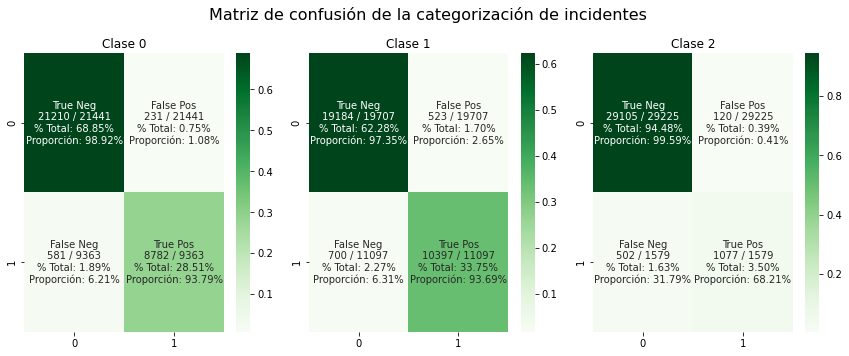

In [53]:
conf_matrix = multilabel_confusion_matrix(y_test,y_mo)

plt.figure(figsize=(12,5))
plt.suptitle('Matriz de confusión de la categorización de incidentes', fontsize=16)
for i in range(3):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    lst = conf_matrix[i].flatten()
    neg = lst[0]+lst[1]
    pos = lst[2]+lst[3]
    counts = [neg, neg, pos, pos]
    group_counts = ['{0:0.0f}'.format(value) for value in
                    conf_matrix[i].flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        conf_matrix[i].flatten()/np.sum(conf_matrix[i])]
    group_accuracy = ['{0:.2%}'.format(value) for value in
                     lst/counts]
    labels = ['%s\n%s / %s\n%% Total: %s\nProporción: %s' % (v1, v2, v4, v3, v5) for v1, v2, v3, v4, v5 in
          zip(group_names,group_counts,group_percentages, counts, group_accuracy)]
    labels = np.asarray(labels).reshape(2,2)
    plt.subplot(1, 3, i+1)
    sns.heatmap(conf_matrix[i]/np.sum(conf_matrix[i]), annot=labels, fmt='', cmap='Greens')
    plt.title('Clase %d'%i, fontsize=12)
plt.tight_layout()
plt.show()

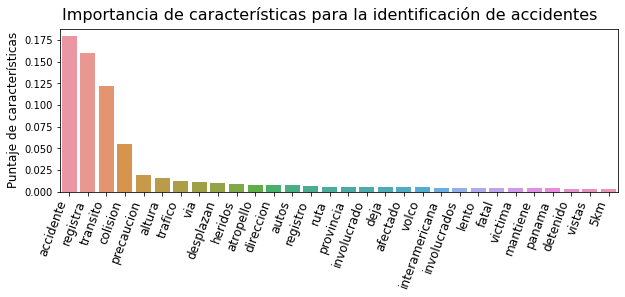

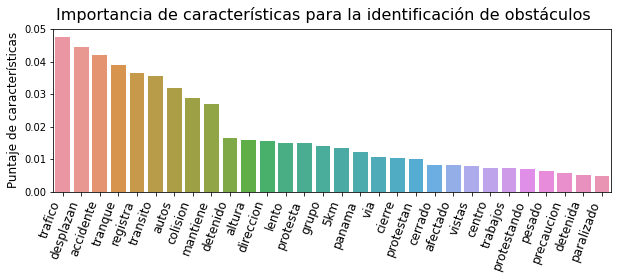

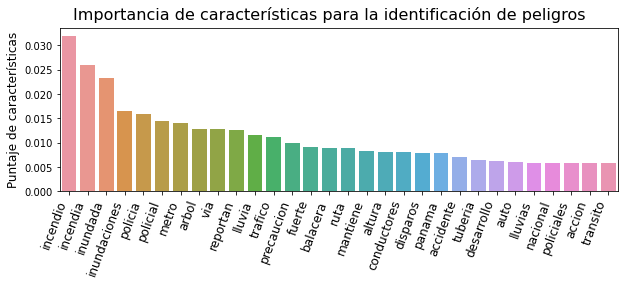

In [57]:
feat_df = pd.DataFrame(X_vect)
feat_df.columns = X1.get_feature_names()

# plt.figure(figsize=(10,10))
titles = {0:'accidentes', 1:'obstáculos', 2:'peligros'}
for i in range(3):
    # plt.subplot(3, 1, i+1)
    plt.figure(figsize=(10,3))
    # feat_imp = pd.Series(mo_classifier.estimators_[i].get_booster().get_fscore()).sort_values(ascending=False)[:40]
    feat_imp = pd.Series(mo_classifier.estimators_[i].feature_importances_).sort_values(ascending=False)[:30]
    # feat_imp.plot(kind='bar', title='Feature] Importances')
    feat_values = [int(i) for i in feat_imp.index]
    feat_names = [feat_df.columns[i] for i in feat_values]
    features = pd.DataFrame({'feature_num':feat_values, 'names':feat_names, 'count':feat_imp.values})
    # feat_values = [int(re.sub('f', '', i)) for i in feat_imp.index]
    # feat_names = [feat_df.columns[i] for i in feat_values]
    # features = pd.DataFrame({'feature_num':feat_values, 'names':feat_names, 'count':feat_imp.values})
    plt.suptitle('Importancia de características para la identificación de ' + titles[i], fontsize=16)
    sns.barplot(x='names', y='count', data=features)
    plt.xticks(rotation=70, fontsize=12, ha='right')
    plt.ylabel('Puntaje de características', fontsize=12)
    # plt.tight_layout()
    plt.xlabel(None)
    plt.show()